### 1. Datenvorbereitung  <a class="anchor" id=" 1. Datenvorbereitung"></a>

### 2. Deskriptive Analyse  <a class="anchor" id=" 2. Deskriptive Analyse"></a>

#### 2.1 Datenanalyse auf Tagesbasis <a class="anchor" id="Datenanalyse auf Tagesbasis "></a>
#### 2.2 Datenanalyse auf Monatsbasis <a class="anchor" id="Datenanalyse auf Monatsbasis"></a>
#### 2.3 Datenanalyse auf Jahresbasis <a class="anchor" id="Datenanalyse auf Jahresbasis"></a>

###  3. Komponentenmodell  <a class="anchor" id="3. Komponentenmodell"></a>

#### 3.1 Trendbreinigung  <a class="anchor" id="3.1 Trendbreinigung"></a>
#### 3.2 Saisonbereinigung  <a class="anchor" id="3.2 Saisonbereinigung"></a>

###  4. Stationarität  <a class="anchor" id=" 4. Stationarität"></a>

#### Section 2.1 <a class="anchor" id="section_2_1"></a>

#### Section 2.2 <a class="anchor" id="section_2_2"></a>
 

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.api import SARIMAX
from sklearn import linear_model
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
import pylab
from math import sqrt
import statsmodels.api as sm
import seaborn as sns

# 1. Datenvorbereitung

In [60]:
serie_2 = pd.read_excel(r"Spotpreise_Gas.xlsx", index_col=0)

Preis = pd.DataFrame(serie_2) 
 
Preis.drop(index = Preis.index[0:2], axis=0, inplace=True)
Preis.columns = ['Gaspreis']
Preis.index.name = 'MESS_DATUM'
print(Preis)



           Gaspreis
MESS_DATUM         
2014-01-01   26.838
2014-01-02     27.1
2014-01-03   26.736
2014-01-04     26.1
2014-01-05     26.1
...             ...
2018-07-27   22.238
2018-07-28    21.92
2018-07-29    21.92
2018-07-30   22.112
2018-07-31   22.238

[1673 rows x 1 columns]


# 2. Deskriptive Analyse


## 2.1 Datenanalyse auf Tagesbasis

In [61]:
Preis["Gaspreis"] = pd.to_numeric(Preis["Gaspreis"], downcast="float")
daily_Preis = Preis.resample('D').mean()
daily_Preis = Preis.apply(pd.to_numeric, errors='coerce') 


## 2.1.1  Autokorrelation

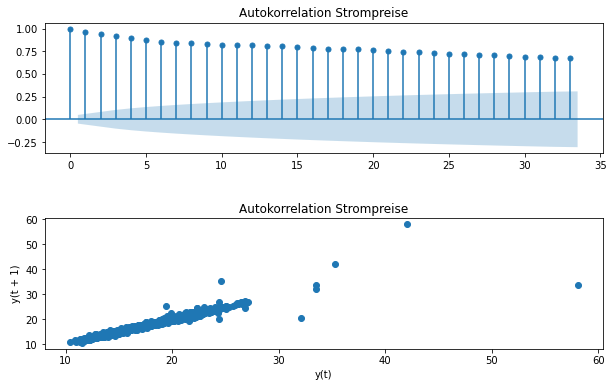

In [62]:
# Visualisierung der Autokorrelation

plt.rcParams["figure.figsize"] = (10, 6)
fig, ax = plt.subplots(2)
plot_acf(Preis, ax=ax[0])
ax[0].set_title("Autokorrelation Strompreise")
lag_plot(Preis, lag=1, ax=ax[1])
ax[1].set_title("Autokorrelation Strompreise")
fig.subplots_adjust(hspace=0.5)
plt.show()


### Interpretation


Sehr starke Korrelation zwischen t-1 und t, diese nimmt jedoch im Laufe der Zeit immer mehr ab.

## 2.2 Datenanalyse auf Monatsbasis




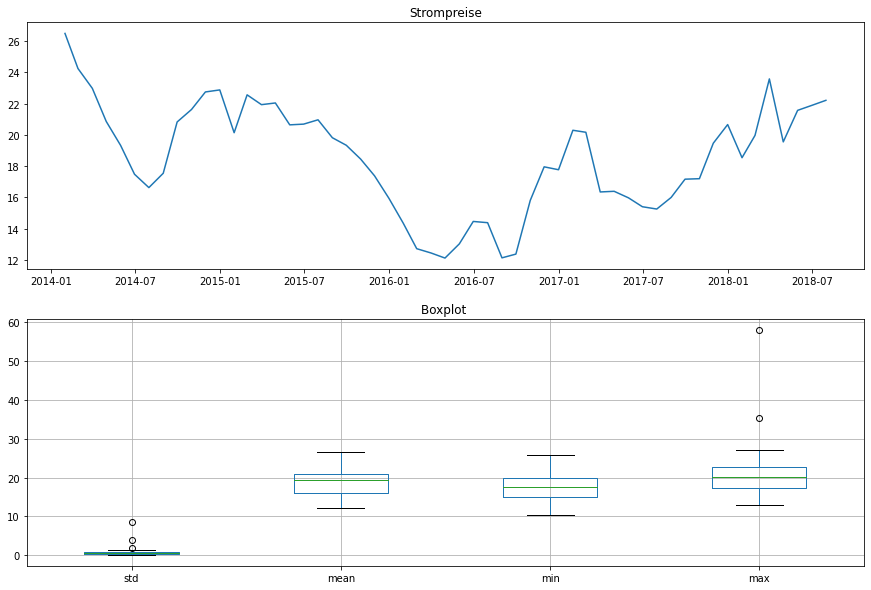

In [63]:
# Monatliche Aggregation von Strompreisdaten

min_Preis = daily_Preis.resample('M').min()
mean_Preis = daily_Preis.resample('M').mean()
std_Preis = daily_Preis.resample('M').std()
max_Preis = daily_Preis.resample('M').max()
month_P = pd.concat([std_Preis, mean_Preis, min_Preis, max_Preis], axis = 1)
month_P.columns = ['std','mean', 'min', 'max']

# Visualisierung Boxplot

def Box_plot(data1,data2):
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    ax[0].set_title('Strompreise')
    ax[1].set_title('Boxplot ')    
    ax[0].plot(data1)
    data2.boxplot()
    plt.show()

Box_plot(month_P['mean'], month_P)



## 2.3 Datenanalyse auf Jahresbasis


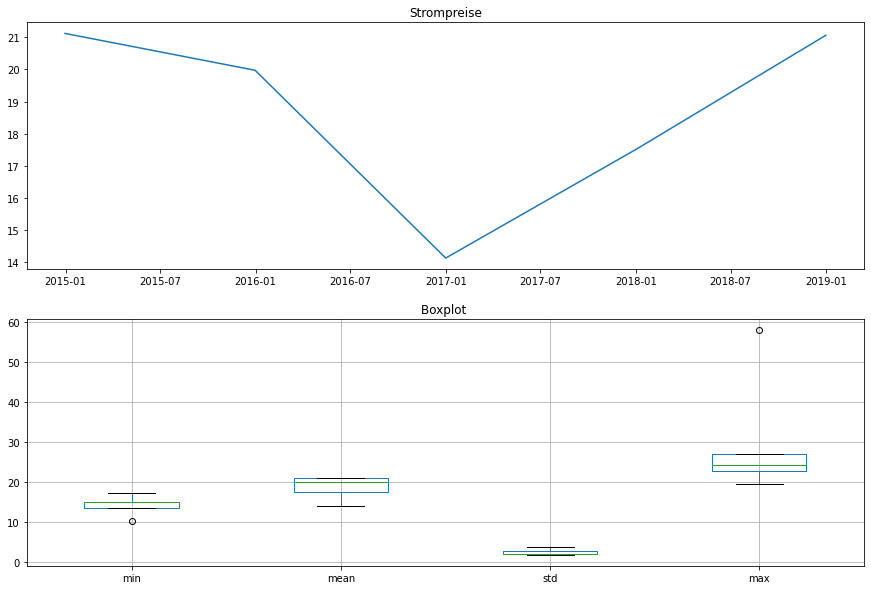

In [64]:
y_min_P = daily_Preis.resample('Y').min()
y_mean_P = daily_Preis.resample('Y').mean()
y_std_P = daily_Preis.resample('Y').std()
y_max_P = daily_Preis.resample('Y').max()
y_P = pd.concat([y_min_P, y_mean_P, y_std_P, y_max_P], axis = 1)
y_P.columns = ['min','mean', 'std', 'max' ]


# Datenvisualisierung

Box_plot(y_P['mean'], y_P)



# 3. Komponentenmodell


## 3.1 Trendbreinigung

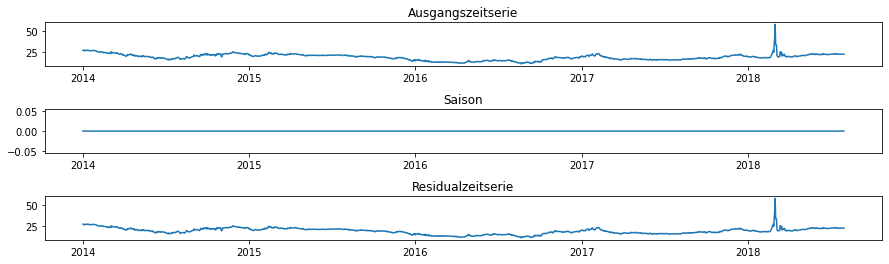

In [65]:
# Trendbereinigung Gaspreis

a_ = Preis.index.values
b_ = Preis['Gaspreis']

# Visualisierung der Ausgangszeitreihe

plt.rcParams["figure.figsize"] = (15, 4)
fig2, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(a_, b_)
ax1.set_title('Ausgangszeitserie')
ax2.plot(a_, np.zeros((a_.shape)))
ax2.set_title('Saison')
ax3.plot(a_,b_ - np.zeros((b_.shape)))
ax3.set_title('Residualzeitserie')
fig2.subplots_adjust(hspace=1)
plt.show()



                             OLS Regression Results                            
Dep. Variable:               Gaspreis   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     94.05
Date:                Sun, 27 Feb 2022   Prob (F-statistic):           1.13e-21
Time:                        17:14:07   Log-Likelihood:                -4523.3
No. Observations:                1673   AIC:                             9051.
Df Residuals:                    1671   BIC:                             9062.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.0308      0.177    113.337      

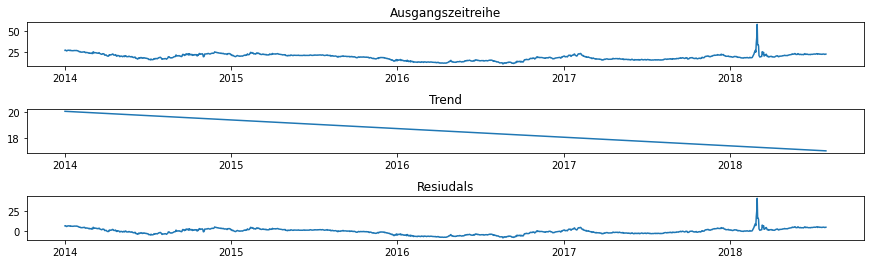

In [66]:
# Formulierung des Vektors X

X_2 = np.arange(Preis['Gaspreis'].shape[0])


# Regressionsmodell Gaspreis

X_2 = sm.add_constant(X_2)
model_2 = sm.OLS(Preis['Gaspreis'].astype(float), X_2.astype(float)) ##warum 
result_2 = model_2.fit()
print('\n\n', result_2.summary())
Preis['g_'] = result_2.predict()
Preis['residuals_'] = Preis['Gaspreis'] - Preis['g_']

# Visualisierung

fig4, (ax1,ax2,ax3) = plt.subplots(3,1)
ax1.plot(a_,b_)
ax1.set_title('Ausgangszeitreihe')
ax2.plot(a_, Preis['g_'])
ax2.set_title('Trend')
ax3.plot(a_,Preis['residuals_'])
ax3.set_title('Resiudals')
fig4.subplots_adjust(hspace=1)

plt.show()




# 3.2 Saisonbereinigung

   d1t  d2t  d3t  d4t  d5t  d6t  d7t
0    0    0    1    0    0    0    0
1    0    0    0    1    0    0    0
2    0    0    0    0    1    0    0
3    0    0    0    0    0    1    0
4    0    0    0    0    0    0    1


                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3151
Date:                Sun, 27 Feb 2022   Prob (F-statistic):              0.929
Time:                        17:14:08   Log-Likelihood:                -4522.4
No. Observations:                1673   AIC:                             9059.
Df Residuals:                    1666   BIC:                             9097.
Df Model:                           6                                         
Covariance Type:            nonrobust                           

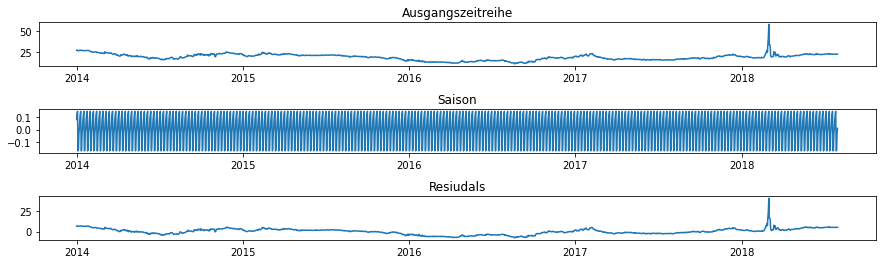

In [67]:
# Saisonbereinigung von Gaspreise (Dummyregression)


Price = daily_Preis.reset_index()
Price['weekday'] = Price['MESS_DATUM'].dt.dayofweek  #[Montag=0, Sonntag=6]

#  Aufbau der Regressoren

X = pd.get_dummies(Price['weekday'])  #Jedem Wochentag wird eine eigene Dummy Variable zugeordnet
X.columns = ['d1t', 'd2t','d3t','d4t','d5t','d6t','d7t']
print(X.head())


# Regressionsmodell ohne Intercept

Y = Preis['residuals_'].to_numpy()   
reg2 = sm.OLS(Y.astype(float), X.astype(float))
SAI_2 = reg2.fit()
Preis['saison_'] = SAI_2.predict()
Preis['residuals_wt_'] = Preis['residuals_'] - Preis['saison_']
print('\n\n', SAI_2.summary())


# Visualisierung

fig3, (ax1,ax2,ax3)=plt.subplots(3,1)
ax1.plot(a_,b_)
ax1.set_title('Ausgangszeitreihe')
ax2.plot(a_, Preis['saison_'])  
ax2.set_title('Saison')
ax3.plot(a_,Preis['residuals_wt_'])
ax3.set_title('Resiudals')
fig3.subplots_adjust(hspace=1)
plt.show()

# 4. Stationarität

## 4.1 Visuelle Prüfung


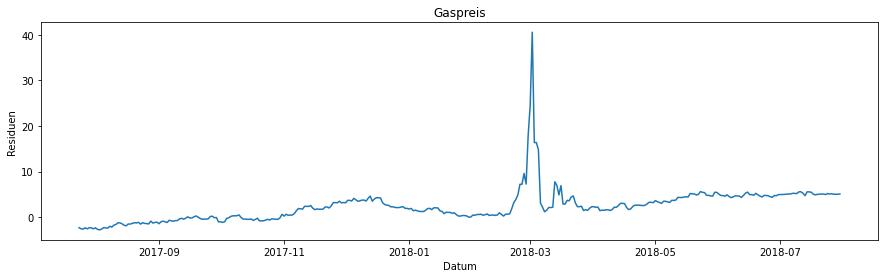

In [68]:

plt.rcParams["figure.figsize"] = (15, 4)
plt.plot(Preis.index.values[1300:-1],Preis['residuals_wt_'].iloc[1300:-1])   
plt.title('Gaspreis')
plt.xlabel('Datum')
plt.ylabel('Residuen')
fig.subplots_adjust(hspace=1, top = 0.9)
plt.show()

## 4.2 ADF-Test



In [69]:
for i in range(1,10):
    
    result_ADF2 = adfuller(Preis['residuals_wt_'].iloc[1300:-1].dropna(), maxlag=i*4)
    print('ADF Statistic GAS: %f' % result_ADF2[0])
    print('p-value: %f' % result_ADF2[1])         
    print('Lags used: %d' % result_ADF2[2])

ADF Statistic GAS: -4.613800
p-value: 0.000122
Lags used: 2
ADF Statistic GAS: -4.613800
p-value: 0.000122
Lags used: 2
ADF Statistic GAS: -2.959191
p-value: 0.038885
Lags used: 10
ADF Statistic GAS: -2.959191
p-value: 0.038885
Lags used: 10
ADF Statistic GAS: -2.959191
p-value: 0.038885
Lags used: 10
ADF Statistic GAS: -2.959191
p-value: 0.038885
Lags used: 10
ADF Statistic GAS: -2.959191
p-value: 0.038885
Lags used: 10
ADF Statistic GAS: -2.959191
p-value: 0.038885
Lags used: 10
ADF Statistic GAS: -2.959191
p-value: 0.038885
Lags used: 10


In [70]:
# Gaspreis

for i in range(1,10):
    result_KPSS2 = sm.tsa.stattools.kpss(Preis['residuals_wt_'].iloc[1300:-1], regression='ct',nlags=i)

    print('KPSS test statistic GAS: %f' % result_KPSS2[0])
    print('p-value: %f' % result_KPSS2[1])
    print('Lags used: %d' % result_KPSS2[2])



KPSS test statistic GAS: 0.278948
p-value: 0.010000
Lags used: 1
KPSS test statistic GAS: 0.199197
p-value: 0.016301
Lags used: 2
KPSS test statistic GAS: 0.159507
p-value: 0.038745
Lags used: 3
KPSS test statistic GAS: 0.136441
p-value: 0.067702
Lags used: 4
KPSS test statistic GAS: 0.121701
p-value: 0.094998
Lags used: 5
KPSS test statistic GAS: 0.111592
p-value: 0.100000
Lags used: 6
KPSS test statistic GAS: 0.104260
p-value: 0.100000
Lags used: 7
KPSS test statistic GAS: 0.098659
p-value: 0.100000
Lags used: 8
KPSS test statistic GAS: 0.094219
p-value: 0.100000
Lags used: 9


C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is great

## 3.4 Differenzenbildung



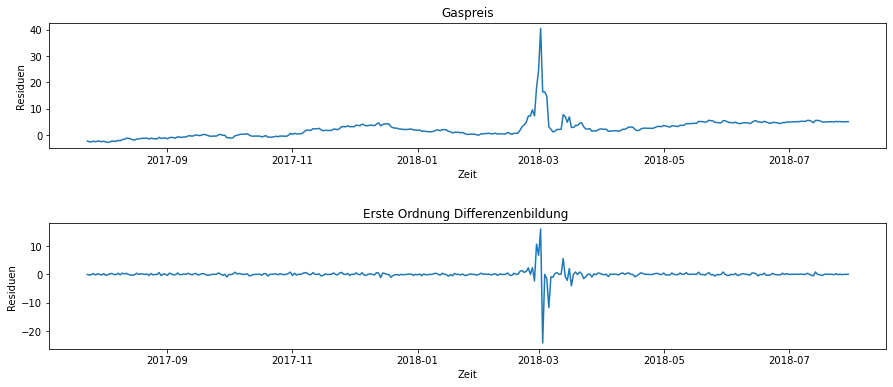

In [71]:
Preis_diff = Preis['residuals_wt_'].diff().iloc[1300:-1]


plt.rcParams["figure.figsize"] = (15, 6)
fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(a_[1300:-1],Preis['residuals_wt_'].iloc[1300:-1])
ax1.set_title('Gaspreis') 
ax1.set_xlabel('Zeit')
ax1.set_ylabel('Residuen')
ax2.plot(a_[1300:-1], Preis_diff)
ax2.set_title('Erste Ordnung Differenzenbildung ') 
ax2.set_xlabel('Zeit')
ax2.set_ylabel('Residuen')

fig.subplots_adjust(hspace=0.6)
plt.show()



## 4. ARMA-Modellierung



## 4.1 Betrachtung ACF 


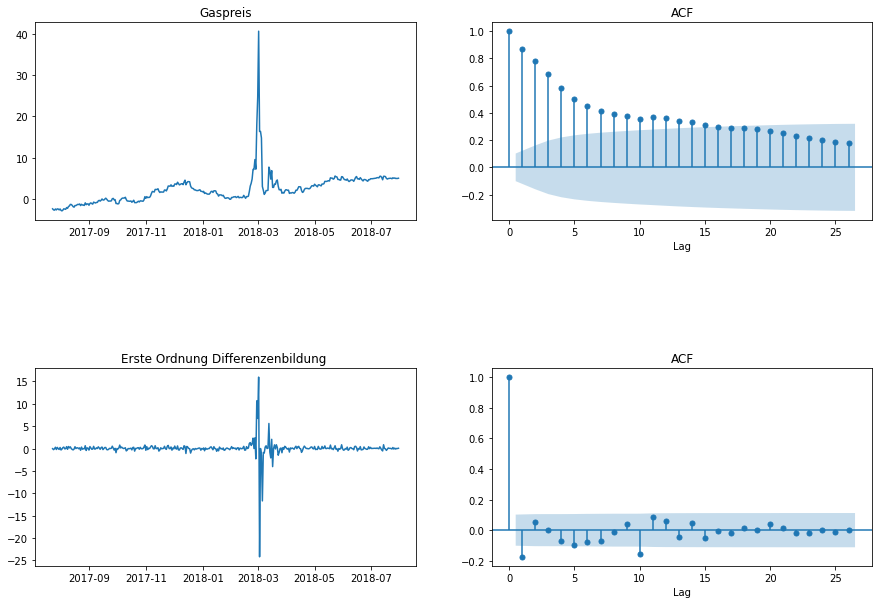

In [72]:
plt.rcParams["figure.figsize"] = (15, 10)
fig, ax = plt.subplots(2,2)
ax[0,0].plot(a_[1300:-1],Preis['residuals_wt_'].iloc[1300:-1])
ax[0,0].set_title('Gaspreis')
plot_acf(Preis['residuals_wt_'].iloc[1300:-1], ax[0,1])
ax[0,1].set_title('ACF')
ax[0,1].set_xlabel('Lag')
ax[1,0].plot(a_[1300:-1], Preis_diff)
ax[1,0].set_title('Erste Ordnung Differenzenbildung ') 
plot_acf(Preis_diff.dropna(),ax[1,1])
ax[1,1].set_title('ACF')
ax[1,1].set_xlabel('Lag')
plt.subplots_adjust(hspace=0.75)                              
plt.show()



## 5.2 Betrachtung PACF

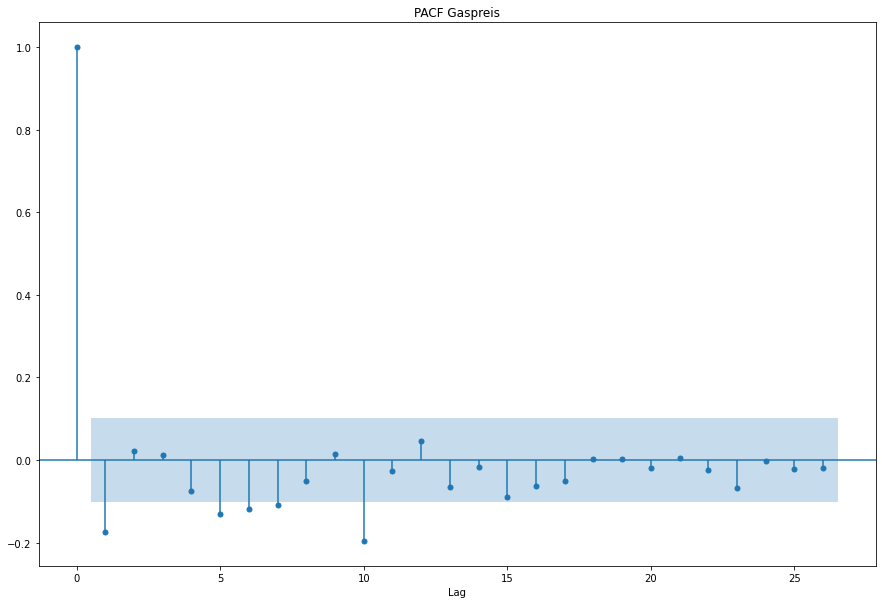

In [73]:
fig, ax1 = plt.subplots(1,1)
plot_pacf(Preis_diff.dropna(), ax=ax1) 
ax1.set_title('PACF Gaspreis')
ax1.set_xlabel('Lag')
plt.subplots_adjust(hspace=0.5)                              
plt.show()



## 5.3 Parametrierung des ARMA-Modells


In [74]:
# ARIMA Model Gaspreis

model_preis = SARIMAX(Preis_diff.dropna().astype(float), order=(1,1,1))
fitted = model_preis.fit()
ARMA_Preis = pd.DataFrame(fitted.predict())
ARMA_Preis.columns = ['Yt']
print('\n\n', fitted.summary()) 

C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'




                                SARIMAX Results                                
Dep. Variable:          residuals_wt_   No. Observations:                  372
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -749.683
Date:                Sun, 27 Feb 2022   AIC                           1505.366
Time:                        17:14:11   BIC                           1517.114
Sample:                    07-24-2017   HQIC                          1510.032
                         - 07-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1715      0.019     -8.880      0.000      -0.209      -0.134
ma.L1         -0.9998      0.277     -3.603      0.000      -1.544      -0.456
sigma2         3.2768      0.892      3.675      

## 5.4 Rückgabe der geschätzten Innovationen



In [75]:
 # Gaspreis

ARMA_Preis['residuals'] = pd.DataFrame(fitted.resid)

print('Eingeschaften der geschätzten Innovationen des Gaspreisprozesses:\n', ARMA_Preis['residuals'].describe()) 

Eingeschaften der geschätzten Innovationen des Gaspreisprozesses:
 count    372.000000
mean      -0.005074
std        1.814262
min      -21.687128
25%       -0.168899
50%       -0.004254
75%        0.182725
max       16.969829
Name: residuals, dtype: float64


## 5.5 Visuelle Prüfung der Stationarität


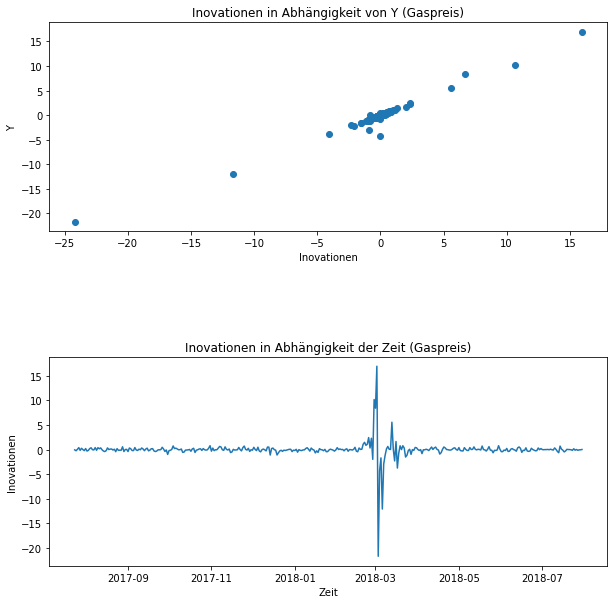

In [76]:
plt.rcParams["figure.figsize"] = (10, 10)
fig, axes = plt.subplots(2)
axes[0].scatter(Preis_diff.dropna(),ARMA_Preis['residuals'])
axes[0].set_title('Inovationen in Abhängigkeit von Y (Gaspreis)')
axes[0].set_xlabel('Inovationen')
axes[0].set_ylabel('Y')
axes[1].plot(ARMA_Preis['residuals'])
axes[1].set_title('Inovationen in Abhängigkeit der Zeit (Gaspreis)')
axes[1].set_xlabel('Zeit')
axes[1].set_ylabel('Inovationen')
plt.subplots_adjust(hspace=0.6)
plt.show()

## 5.6 Prüfung der Unabhängigkeit

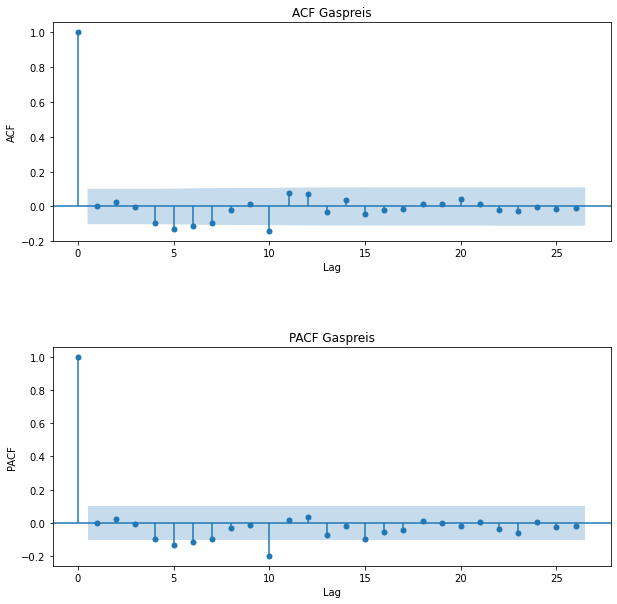

In [77]:
fig, ax = plt.subplots(2)
plot_acf(ARMA_Preis['residuals'].dropna(), ax=ax[0])
ax[0].set_title('ACF Gaspreis')
ax[0].set_ylabel('ACF')
ax[0].set_xlabel('Lag')
plot_pacf(ARMA_Preis['residuals'].dropna(), ax=ax[1])
ax[1].set_title('PACF Gaspreis')
ax[1].set_ylabel('PACF')
ax[1].set_xlabel('Lag')
fig.subplots_adjust(hspace=0.48)
plt.show()

## 5.7 Prüfung der Unabhängigkeit mithilfe des Ljung-Box-Tests


In [78]:
# Durchführung des Ljung-Box-Tests auf Temperaturresiduen mit Lag=1

sm.stats.acorr_ljungbox(ARMA_Preis['residuals'].dropna(), lags=[1], return_df=True)



,lb_stat,lb_pvalue
1,0.000508,0.982024


## 5.8 Prüfung der Normalverteilung (Jarque Bera Test)



In [79]:
stats.jarque_bera(ARMA_Preis['residuals'])

Jarque_beraResult(statistic=105954.8332371155, pvalue=0.0)

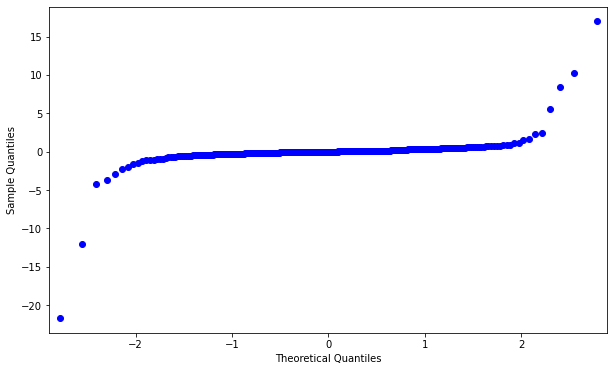

In [80]:
# Graphische überprÜfung der Normalverteilung mittels QQ-Plot


plt.rcParams["figure.figsize"] = (10, 6)
sm.qqplot(ARMA_Preis['residuals'].dropna())
plt.show()

# 6. GARCH Modellierung

## 6.1 Visuelle Prüfung

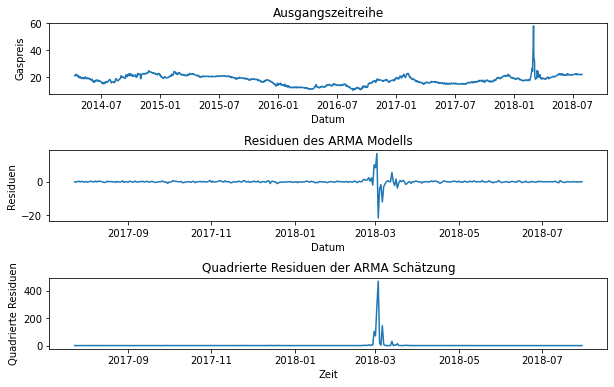

In [81]:
squared_resid2 = ARMA_Preis['residuals'].dropna() ** 2

# Visualisierung

fig, axes = plt.subplots(3,1)
axes[0].set_title('Ausgangszeitreihe')
axes[0].plot(a_[100:-1],Preis['Gaspreis'].iloc[100:-1])
axes[0].set_xlabel('Datum')
axes[0].set_ylabel('Gaspreis')
axes[1].set_title('Residuen des ARMA Modells')
axes[1].plot(ARMA_Preis['residuals'].dropna())
axes[1].set_xlabel('Datum')
axes[1].set_ylabel('Residuen')
axes[2].set_title('Quadrierte Residuen der ARMA Schätzung')
axes[2].plot(squared_resid2)
axes[2].set_xlabel('Zeit')
axes[2].set_ylabel('Quadrierte Residuen')
fig.subplots_adjust(hspace=0.8)
plt.show()

# 6.2 ACF und PACF Analyse


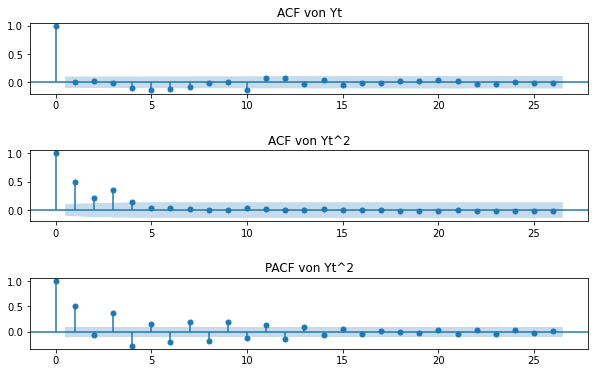

In [82]:
fig, axes = plt.subplots(3,1)
plot_acf(ARMA_Preis['residuals'], axes[0])
axes[0].set_title('ACF von Yt')
plot_acf(squared_resid2, axes[1])
axes[1].set_title('ACF von Yt^2')
plot_pacf(squared_resid2, axes[2])
axes[2].set_title('PACF von Yt^2')
fig.subplots_adjust(hspace=0.8)
plt.show()

## 6.3 Box Ljung Test

In [83]:

for i in range(1,10):
    
    lb_test2 = sm.stats.acorr_ljungbox(squared_resid2, lags=[i], return_df=True)
    print(lb_test2)

     lb_stat     lb_pvalue
1  94.487927  2.465918e-22
      lb_stat     lb_pvalue
2  110.526434  9.988260e-25
      lb_stat     lb_pvalue
3  155.716986  1.539419e-33
      lb_stat     lb_pvalue
4  163.501567  2.593331e-34
      lb_stat     lb_pvalue
5  164.063495  1.346847e-33
      lb_stat     lb_pvalue
6  164.763554  5.797271e-33
      lb_stat     lb_pvalue
7  164.874378  3.019423e-32
      lb_stat     lb_pvalue
8  164.883073  1.521528e-31
      lb_stat     lb_pvalue
9  164.890302  7.145975e-31


## 6.4 Engle ARCH Test zur Überprüfung von Heteroskedastizität



In [84]:
# Gaspreis

Engel_arch2 = het_arch(squared_resid2, maxlag=10)
print(f'Lagrange mulitplier p-value: {Engel_arch2[1]}')
print(f'F test p-value: {Engel_arch2[3]}')

Lagrange mulitplier p-value: 8.765104313461576e-08
F test p-value: 2.287231335323205e-08


<ipython-input-84-cc446cf41f29>:3: FutureWarning: the 'maxlag'' keyword is deprecated, use 'nlags' instead
  Engel_arch2 = het_arch(squared_resid2, maxlag=10)


## 6.5 Schätzung des Modells



In [85]:
!pip install arch
from arch import arch_model

p_rng = range(1,4)
q_rng = range(2,6)

for p in p_rng:
    
        for q in q_rng:
            
            model_garch = arch_model(ARMA_Preis['residuals'][1:], mean = 'Constant', vol = 'GARCH', p=p, q=q)
            results_garch = model_garch.fit(update_freq = 10)
            print('GARCH ({}.{}): {}'.format(p,q, results_garch.summary()))
            GARCH_Preis = pd.DataFrame(results_garch.resid)
            GARCH_Preis.columns = ['Residuals']
            GARCH_Preis['STand_residuals']= np.divide(GARCH_Preis['Residuals'], results_garch.conditional_volatility)

Iteration:     10,   Func. Count:     71,   Neg. LLF: 198.29971025575418
Optimization terminated successfully    (Exit mode 0)
            Current function value: 196.10486706705
            Iterations: 17
            Function evaluations: 114
            Gradient evaluations: 17
GARCH (1.2):                      Constant Mean - GARCH Model Results                      
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -196.105
Distribution:                  Normal   AIC:                           402.210
Method:            Maximum Likelihood   BIC:                           421.791
                                        No. Observations:                  371
Date:                Sun, Feb 27 2022   Df Residuals:                      370
Time:                        17:14:21   Df Model:                         

Iteration:     20,   Func. Count:    176,   Neg. LLF: 191.64080026311956
Optimization terminated successfully    (Exit mode 0)
            Current function value: 191.60166045341566
            Iterations: 25
            Function evaluations: 215
            Gradient evaluations: 25
GARCH (2.3):                      Constant Mean - GARCH Model Results                      
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -191.602
Distribution:                  Normal   AIC:                           397.203
Method:            Maximum Likelihood   BIC:                           424.617
                                        No. Observations:                  371
Date:                Sun, Feb 27 2022   Df Residuals:                      370
Time:                        17:14:22   Df Model:                      

GARCH (3.3):                      Constant Mean - GARCH Model Results                      
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -191.602
Distribution:                  Normal   AIC:                           399.203
Method:            Maximum Likelihood   BIC:                           430.533
                                        No. Observations:                  371
Date:                Sun, Feb 27 2022   Df Residuals:                      370
Time:                        17:14:22   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.7716e-03  2.194e-02      0.17

## 5.7 Überprüfung der Eigenschaften der Residuen

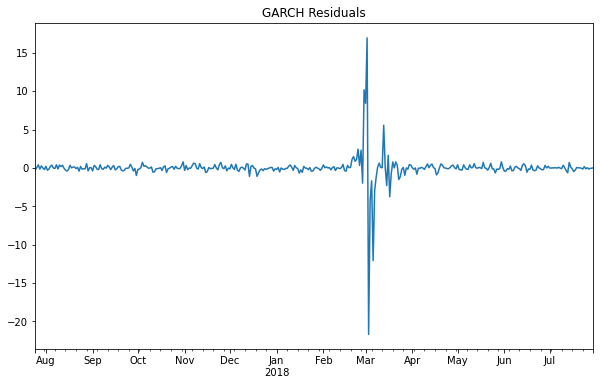

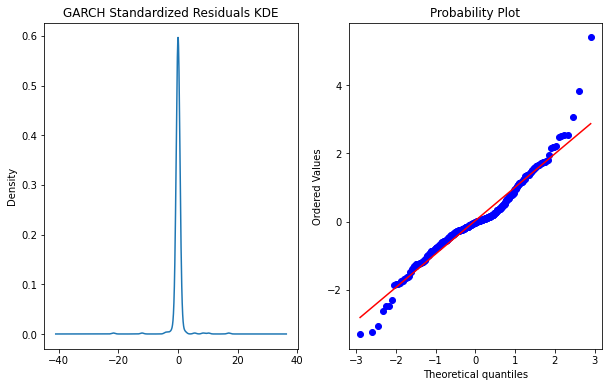

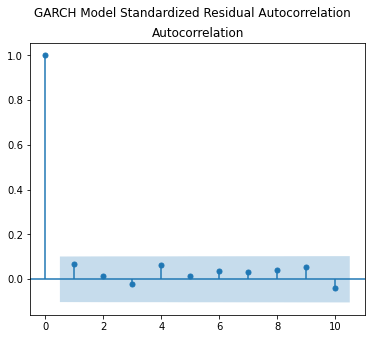

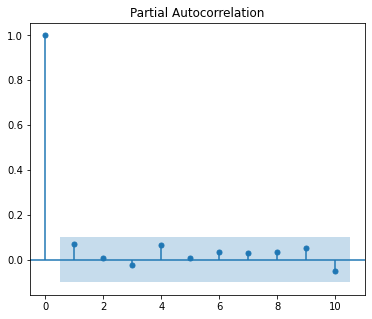

In [86]:
def resid_plot(residuals, stand_residuals, lags=10):
    
    residuals.plot(title='GARCH Residuals', figsize=(10, 6))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    stats.probplot(stand_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stand_residuals, lags=lags)
    pacf = plot_pacf(stand_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=12)
    acf.set_figheight(5)
    acf.set_figwidth(6)
    pacf.set_figheight(5)
    pacf.set_figwidth(6)
    plt.show()

resid_plot(GARCH_Preis['Residuals'], GARCH_Preis['STand_residuals'])

## 6.7 Jarque Bera Test



In [87]:
def model_evaluate(stand_residuals, lags=50):
    
    results = {'pvalue': None, 'statistic': None}
    
    Jarque_bera_test = stats.jarque_bera(stand_residuals)
    
    results['statistic'] = Jarque_bera_test[0]
    results['pvalue'] = Jarque_bera_test[1]
    
    if results['pvalue'] < 0.05:
        
        print('Nullhypothese wird abgelehnt. Die Residuen sind nicht normalverteilt')
        return results
    
    else:
        
        print('Nulllhypothese wird nicht abgelehnt. Die Residuen sind normalverteilt')
        return results

model_evaluate(GARCH_Preis['STand_residuals'])

Nullhypothese wird abgelehnt. Die Residuen sind nicht normalverteilt


{'pvalue': 0.0, 'statistic': 163.85586981141648}

In [88]:
# Daten abspeichern


Preis.to_excel('/Users/lailafdoul/Desktop/EDA/Kompo_Preis.xls', index=False)
ARMA_Preis.to_excel('/Users/lailafdoul/Desktop/EDA/ARMA_Preis.xls', index=False)
GARCH_Preis.to_excel('/Users/lailafdoul/Desktop/EDA/GARCH_Preis.xls', index=False)

<ipython-input-88-ebff586088f8>:4: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  Preis.to_excel('/Users/lailafdoul/Desktop/EDA/Kompo_Preis.xls', index=False)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/lailafdoul/Desktop/EDA/Kompo_Preis.xls'